# Importando as bibliotecas

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

%matplotlib inline

# Base Info:
Nome: Rice Dataset (Commeo and Osmancik)     
Resumo: Um total de 3810 imagens de grãos de arroz foram tiradas de duas espécies (Cammeo e Osmancik).      
- As imagens foram pré-processadas e certos atributos foram inferidos     
- Sete atributos morfológicos foram obtidos para cada imagem de grão de arroz
    - Area (integer)
    - Perimeter (float)
    - **Major_Axis_Length (float)** -> atributos utilizados
    - **Minor_Axis_Length (float)** -> atributos utilizados
    - Eccentricity (float)
    - Extent (float)
- Classes:
    - Cammeo
    - Osmancik

	



In [48]:
df = pd.read_csv('./rice+cammeo+and+osmancik/rice.csv', header=None)
y = df.iloc[0:, 7].values
y.size

3810

In [40]:
y = np.where(y == 'Cammeo', -1, 1) # realizado o tratamento do classe categorica (string -> int)
y

array([-1, -1, -1, ...,  1,  1,  1])

In [41]:
X = df.iloc[0:, [2,3]].values # atributos utilizados
X.size

7620

# Separando a base em treinamento e teste

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102) # 80% treinamento 20% teste

# Objeto Neuronio, seus atributos e métodos

In [43]:
# base
# classe Neuronio e aprendizado estocastico/online

class Neuronio(object):

    def __init__(self, eta=0.1, epocas=50, fativ='perceptron',showErro=False):
        self.eta = eta
        self.epocas = epocas
        self.w_ = np.random.rand(1 + X.shape[1]) - 0.5
        self.fativ = fativ
        self.showErro = showErro
        self.erro_ep = 0
        self.SqError_ = []

    def somat(self, X):
        return self.w_[0] + np.dot(X, self.w_[1:])

    def sinal(self, x):
        return np.where(x >= 0.0, 1, -1)

    def tanh(self, x):
      return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

    def d_tanh(self, x):
      return 1 - self.tanh(x) * self.tanh(x)

    def ReLU(self, x):
      return np.where(x > 0.0, x, 0.1*x)  #max(0, x) .... float

    def d_ReLU(self, x):
      return np.where(x > 0.0, 1, 0.1)

    def predict(self,X):
      if self.fativ == 'sinal' or self.fativ == 'perceptron':
#        print(f"sinalPredict={self.sinal(self.somat(X))}")  # debug
        return self.sinal(self.somat(X))
      elif self.fativ == 'linear':
        return self.somat(X)
      elif self.fativ == 'tanh':
        return self.tanh(self.somat(X))
      elif self.fativ == 'ReLU':
        return self.ReLU(self.somat(X))
      else:
        return 11

    def deltaW(self, erro):
      if self.fativ == 'sinal' or self.fativ == 'perceptron':
        atualiza = self.eta * erro
      elif self.fativ == 'linear':
        atualiza = self.eta * erro
      elif self.fativ == 'tanh':
#        print(f"> eta={self.eta} tanh={self.tanh(erro)} dtanh={self.d_tanh(erro)} erro={erro}")
        atualiza = self.eta * self.d_tanh(erro) * erro
      elif self.fativ == 'ReLU':
        atualiza = self.eta * self.d_ReLU(erro) * erro
      else:
        print(f"Função de ativação '{self.fativ}' desconhecida")
        exit()
      return atualiza

    def treinaGD(self,X,y):
      self.SqError_ = []
      self.erros_classif_ = []
      for ep in range(self.epocas):
        erro_classif = 0
        indices = np.arange(X.shape[0])
        np.random.shuffle(indices)
        Xs = X[indices]
        ys = y[indices]
        outputs = self.predict(Xs)
        erros = (ys - outputs)
       # print(outputs,erros)
        erro_classif = np.where(ys*outputs < 0, 1, 0).sum()
        self.erros_classif_.append(erro_classif)
        if ep < (self.epocas-1):
          self.w_[1:] += self.eta * Xs.T.dot(erros)
          self.w_[0] += self.eta * erros.sum()
        SqError = (erros**2).sum() / 2.0 # ou np.square(erros)/2
        self.SqError_.append(SqError)
        if self.showErro:
          if ep == 0:
            print(f"{'Época':^10}\tErro")
          else:
            print(f"{str(ep):^10}\t{erro_classif}")
      return self

    def treinaSGD(self, X, y):
        self.erros_ = []
        self.erros_classif_ = []
        self.SqError_ = []
        for ep in range(self.epocas):
            erro_ep = 0
            erro_classif = 0
            SqError = 0

            indices = np.arange(X.shape[0])
            np.random.shuffle(indices)
            Xs = X[indices]
            ys = y[indices]

            for xi, target in zip(Xs, ys):
              output = self.predict(xi)
              erro = target - output
              SqError += erro*erro
              erro_ep += erro
              if (float(target)*float(output)) < 0:
                #print(f"ep={ep} {xi} target={target} output={output} t*o={target*output}") # debug
                erro_classif += 1

              if (ep < (self.epocas-1)):  #
                atualizacao = self.deltaW(erro)
                self.w_[0] +=  atualizacao * 1
                self.w_[1:] +=  atualizacao * xi

            self.erros_.append(erro_ep)
            self.SqError_.append(SqError)
            self.erros_classif_.append(erro_classif)
            if self.showErro:
              if ep == 0:
                print(f"{'Época':^10}\tErro")
              else:
                print(f"{str(ep):^10}\t{erro_classif}")

        return self

In [44]:
classifier_ = []
W0_ = []
training_type = ['SGD', 'GD']
for type in training_type:
  # cria objeto
  print(f'Tipo de treino: {type}')
  np.random.seed(35)  # deixar reproduzível
  classifier = Neuronio(fativ='tanh', eta=0.0001, epocas=150,showErro=False)
  W0 = classifier.w_.copy()
  W0_.append(W0)
  # treinamento
  np.random.seed(35)
  if type=='SGD':
    classifier.treinaSGD(X_train, y_train)
  else:
    continue
    classifier.treinaGD(X_train, y_train)
  classifier_.append(classifier)

Tipo de treino: SGD
Tipo de treino: GD


# Métricas

In [45]:
preds = []
PercClassifica = []
for c in classifier_:
    pred = c.predict(X_test)
    preds.append(pred)
    PercClassifica.append(100 * np.where(pred*y_test < 0, 0, 1).sum() / len(y_test))
PercClassifica


[76.77165354330708]

In [46]:
categ_preds = np.where(preds[1] < 0, -1, 1)
cm = confusion_matrix(y_test, categ_preds)
print(cm)
accuracy_score(y_test, categ_preds)

IndexError: list index out of range

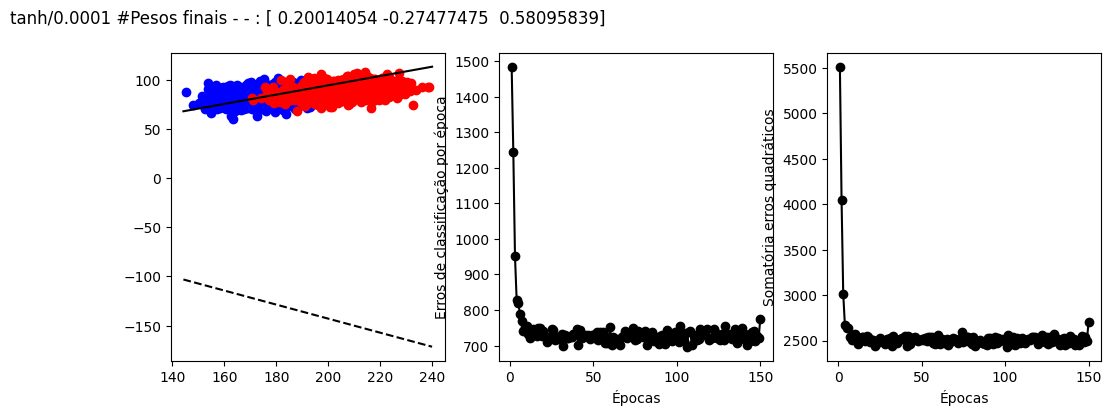

In [47]:
# função para traçar reta no plano cartesiano (x2 = f(x1))
def coord(w0,w1,w2,x1):
  if w2 != 0:
    return (-w0-w1*x1)/w2
  else:
    return 2000 # Inf

def plota1(rna):
  # base
  x1, y1 = X[y==1,0],X[y==1,1]
  x0, y0 = X[y==-1,0], X[y==-1,1]
  ylim = [min(min(x1) , min(x0))-1, max(max(x0) , max(x1))+1]
  x = np.linspace(ylim[0], ylim[1], 2)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12, 4))

  # mostra o classificador antes e depois do treinamento
  titulo = f'{rna.fativ}/{rna.eta} #Pesos finais - - : {rna.w_}\n '
  ax1.set_title(titulo)
  ax1.ylim = [min(min(x1) , min(x0))-1, max(max(x0) , max(x1))+1]
  ax1.scatter(x1,y1, color='blue')
  ax1.scatter(x0,y0,color='red')
  ax1.plot(ylim,coord(W0[0],W0[1],W0[2], x),color='black',linestyle='dashed')
  ax1.plot(ylim,coord(rna.w_[0],rna.w_[1],rna.w_[2], x),color='black')

  ax2.plot(range(1, len(rna.erros_classif_)+1), rna.erros_classif_, marker='o',color='black')
  ax2.set_xlabel('Épocas')
  ax2.set_ylabel('Erros de classificação por época')
  # evolução do custo
  ax3.plot(range(1, len(rna.SqError_)+1), rna.SqError_, marker='o', color='black')
  ax3.set_xlabel('Épocas')
  ax3.set_ylabel('Somatória erros quadráticos')

for ind in range(len(classifier_)):
  plota1(classifier_[ind])